In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 195 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 109.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 105.7 MB/s eta 0:00:01


In [1]:
import torch
from torchvision import transforms
import torch.nn as nn
import numpy as np
import os
import sys
from glob import glob
import collections

In [2]:
from classifier_networks import VGG, vgg_layers, CNN
from GAN_models.gan_load import make_style_gan2

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [4]:
#import seaborn as sns
import pandas as pd

In [5]:
device = torch.device('cuda:0')

In [6]:
def linspace(start, stop, num):
    """
    Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
    Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.
    """
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)
    
    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)
    
    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps*(stop - start)[None]
    
    return out

In [7]:
class Args:
    def __init__(self):
        self.gan_weights= 'GAN_models/pretrained/generators/StyleGAN2/stylegan2-ffhq-config-f.pt'
        self.classifier_weights= 'classifier_weights/celebA_MultiLabels_vgg11_classifier.pt'
        self.classifier_network= 'VGG'
        self.class_count= 39
        self.latent_dim= 512
        self.scale_loss_ratio= 0.05 #faithfulness
        self.gan_output_dim= 1024
        self.gan_output_channel= 3
        self.classifier_input_dim= 256
        self.classifier_input_channel=3
        self.batch_size= 1
        self.n_steps= 100000
        self.lr= 1e-4
        self.batch_noise_scale= 0.1
        #self.training_name= 'FACE_Multi'
        #self.multi_task = True
        self.shift_model_weight = 'weights/FACE_0.050_SharmaAttrs+Attractive.pt'
        self.subset_labels = [1,25,11,17,28,27,34,16,3] #add attracitve# Pale_Skin, Bushy_Eyebrows, Heavy_Makeup, Rosy_Cheeks, Receding_hairline, Wearing_Hat, Gray_Hair, Bald
        self.target_label = [1] # Attractiveness
args = Args()

In [8]:
all_labels = np.load('./celebA_labels.npy') # the list of labels for CelebA dataset
labels = np.array(all_labels)[args.subset_labels+args.target_label] 

In [56]:
all_labels

array(['Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
       'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose',
       'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling',
       'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat',
       'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='<U19')

In [10]:
GAN_weight_file = args.gan_weights
gan_resolution = args.gan_output_dim

classifier_weight_file = args.classifier_weights
classifier_network = args.classifier_network
class_count = args.class_count
classifier_input_size = 256
latent_size = args.latent_dim

#number of attributes
attribute_count = len(args.subset_labels)

batch_size = 1

In [11]:
class_count

39

In [12]:
resize_transform = transforms.Scale((classifier_input_size,classifier_input_size)) # A transformation to resize images from GAN output to classifier input

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [13]:
class FCShiftPredictor(nn.Module):
    def __init__(self,input_dim,class_dim, inner_dim, output_dim):
        super(FCShiftPredictor, self).__init__()
        self.fc_direction = nn.Sequential(
            nn.Linear(input_dim+class_dim,inner_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(inner_dim,inner_dim),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(inner_dim,output_dim),
        )
        
    def forward(self, x,c):
        x_c = torch.cat((x,c),1)
        dir_ = self.fc_direction(x_c)
        return dir_

In [14]:
# Load the shift predictor
shift_model = torch.load(args.shift_model_weight)
shift_model = shift_model.eval()

In [15]:
# Load GAN model
G = make_style_gan2(gan_resolution, GAN_weight_file)
G.eval()
G = G.to(device)

In [16]:
# Load the classifier
classifier_weights = torch.load(classifier_weight_file)

if isinstance(classifier_weights, collections.OrderedDict):
    if classifier_network == 'VGG':
        classifier = VGG(vgg_layers,class_count)
    elif classifier_network == 'CNN':
        classifier = CNN()
    elif classifier_network == 'ResNet50':
        raise ValueError('Classifier architecture {} is not imlplemented.'.format(classifier_network))
    else:
        raise ValueError('Classifier architecture {} is not defined.'.format(classifier_network))
    classifier.load_state_dict(classifier_weights)

elif isinstance(classifier_weights,dict):
    if 'model' in classifier_weights:
        classifier_weights = classifier_weights['model']
    else:
        print('Classifier weights file includes:',classifier_weights.keys())
        raise ValueError('Classifier weight file has an unknown format.')
else:
    classifier = classifier_weights

classifier = classifier.to(device)
classifier = classifier.eval()

In [17]:
#magic starts

In [71]:
z_perturb = torch.randn([1,latent_size]).repeat(batch_size,1).to(device)

In [72]:
w = G.style_gan2.get_latent(z_perturb)

In [74]:
img_orig = G.style_gan2([w], input_is_latent=True)[0]
img_orig = resize_transform(img_orig)
y_orig = classifier(img_orig)
y_orig = torch.sigmoid(y_orig[0])

In [75]:
y_orig.shape

torch.Size([1, 39])

In [76]:
# Pale_Skin, Bushy_Eyebrows, Heavy_Makeup, Rosy_Cheeks, Receding_hairline, Wearing_Hat, Gray_Hair, Bald

In [77]:
# Now we want to run the shift predictor in the direction of each attribute
#         [w0]                | 1 0 0 0 0 0 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Pale_Skin -> 1.0
#         |w0|                | 0 1 0 0 0 0 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Bushy_Eyebrows -> 1.0
#         |w0|                | 0 0 1 0 0 0 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Heavy_Makeup -> 1.0
# w_rep = |w0|     y_target = | 0 0 0 1 0 0 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Rosy_Cheeks -> 1.0
#         |w0|                | 0 0 0 0 1 0 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Receding_hairline -> 1.0
#         |w0|                | 0 0 0 0 0 1 0 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Wearing_Hat -> 1.0
#         [w0]                | 0 0 0 0 0 0 1 0 |   --> shift_model(w,y_t) produces w' which is in the direction of Gray_Hair -> 1.0
#         [w0]                | 0 0 0 0 0 0 0 1 |   --> shift_model(w,y_t) produces w' which is in the direction of Bald -> 1.0
w_rep = w.repeat(attribute_count,1)
y_target = torch.eye(attribute_count).to(device)

In [78]:
attribute_count

9

In [79]:
y_target[0,3]=1 #attractive and rosy cheek

In [80]:
y_target

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [81]:
## you can produce a shift in any combination of attributes too, for example for P(w | pale_skin = 1.0 , Gray_Hair = 1.0) 
## you should run shift_model(w,[1 0 0 0 0 0 0 1 0])

In [82]:
y_target.shape

torch.Size([9, 9])

In [83]:
dir_pred = shift_model(w_rep,y_target)

In [90]:
dir_pred.shape#9 directions as ytarget had 9

torch.Size([9, 512])

In [84]:
## if you want to see the image at the end of each direction use the following:
#img_shift = G.style_gan2([w_rep + dir_pred], input_is_latent=True)[0]

In [85]:
# used in visualization number of steps of interpolation 
# between the original point and the counterfactual point (number of images)
path_steps = 4

In [18]:
# The original input point
plt.imshow(img_orig[0].permute(1,2,0).detach().cpu().numpy())

NameError: name 'img_orig' is not defined

In [146]:
w_rep.shape

torch.Size([9, 512])

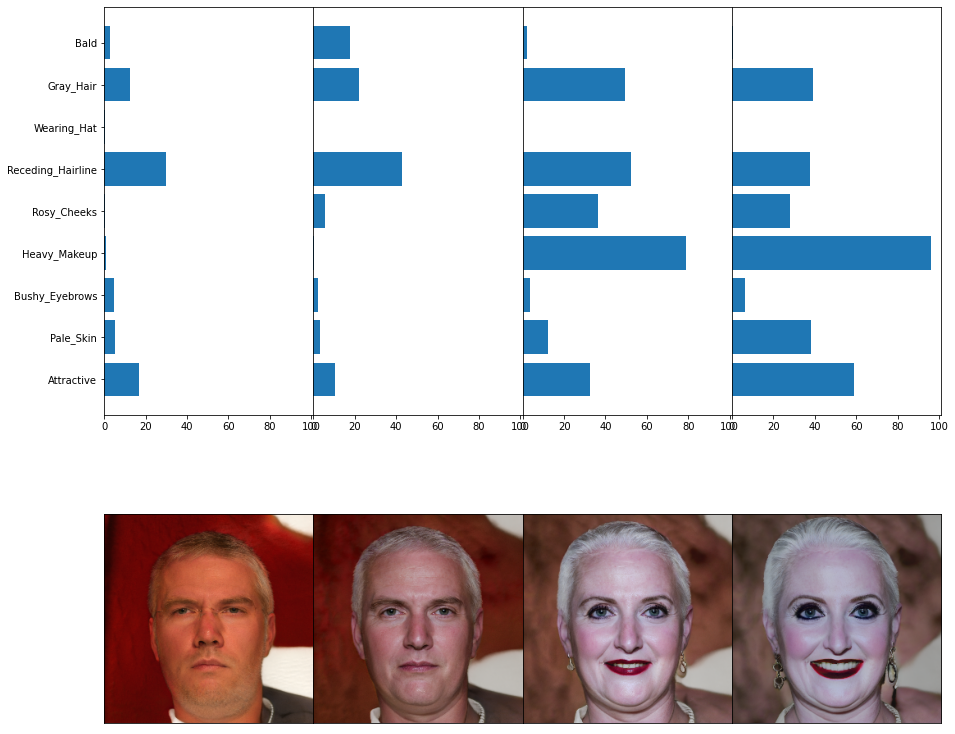

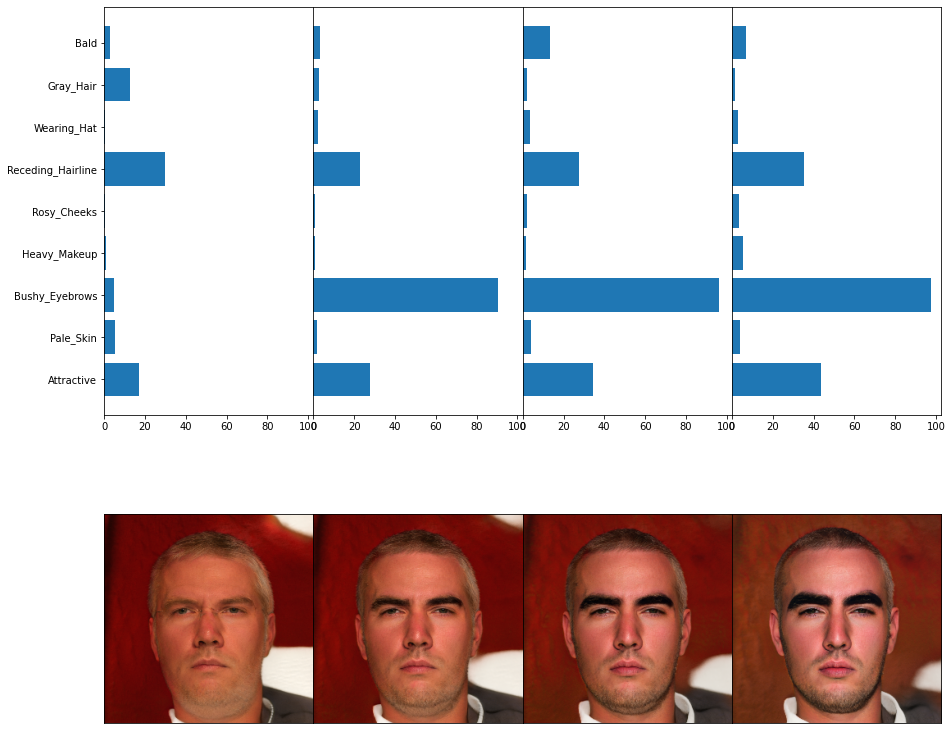

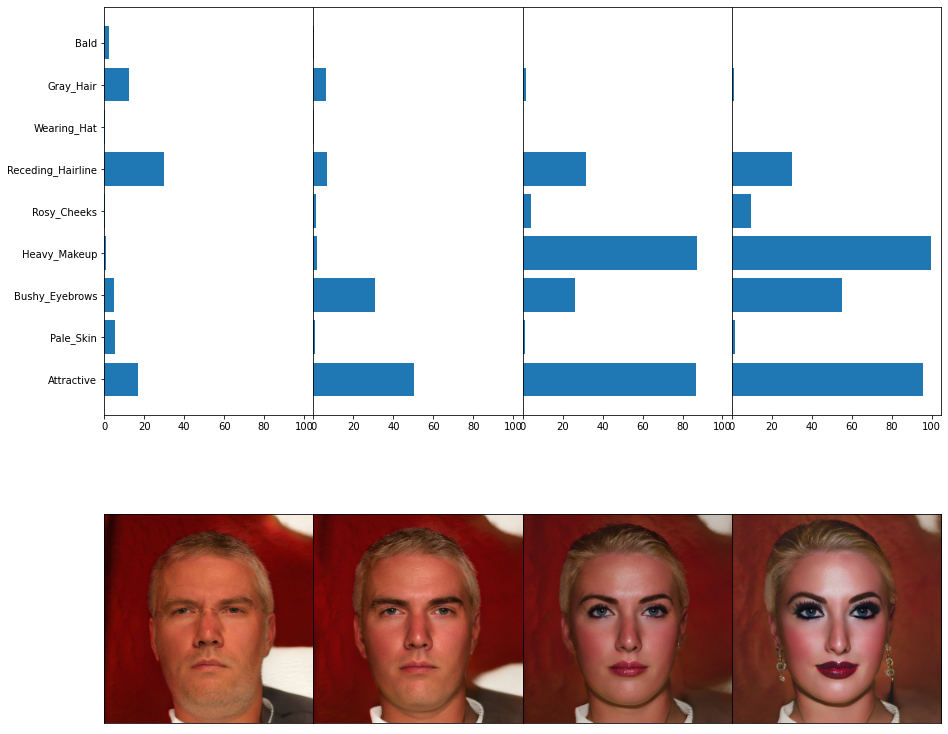

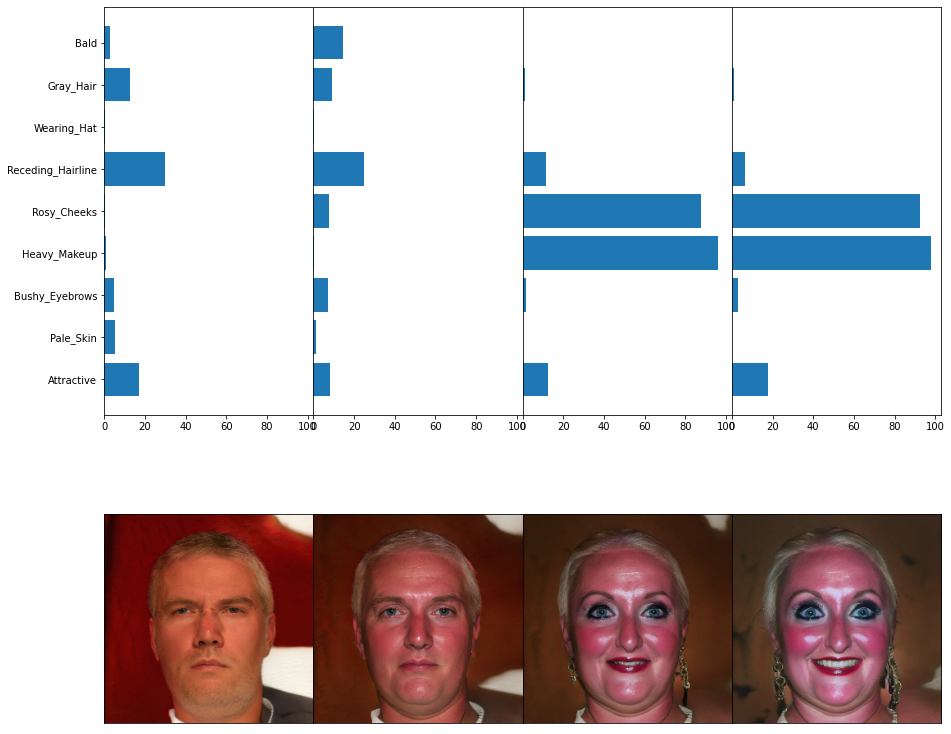

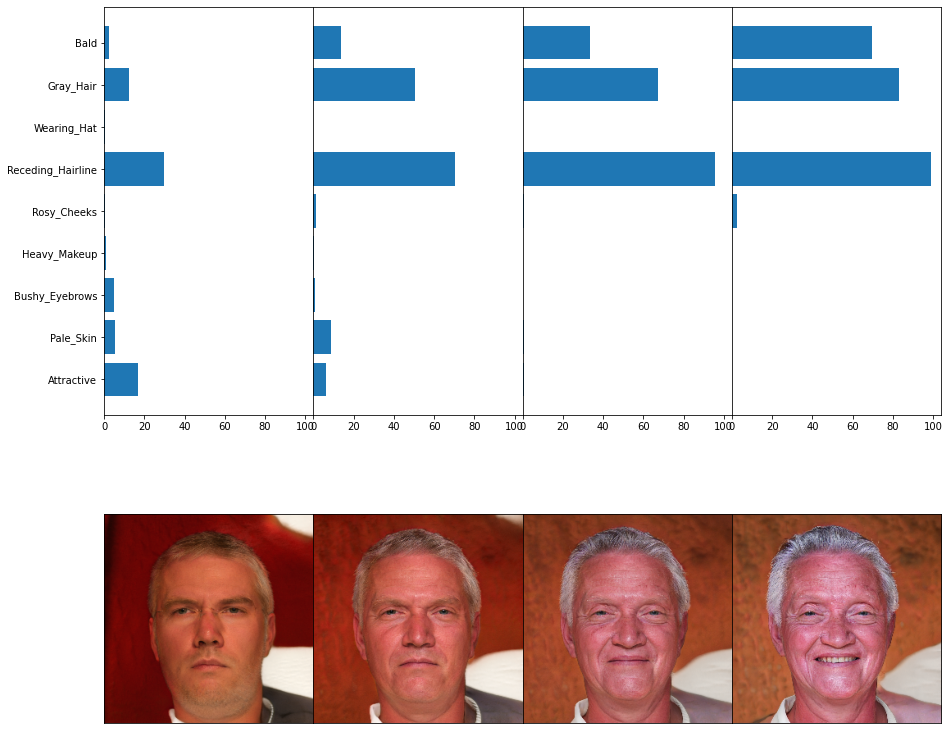

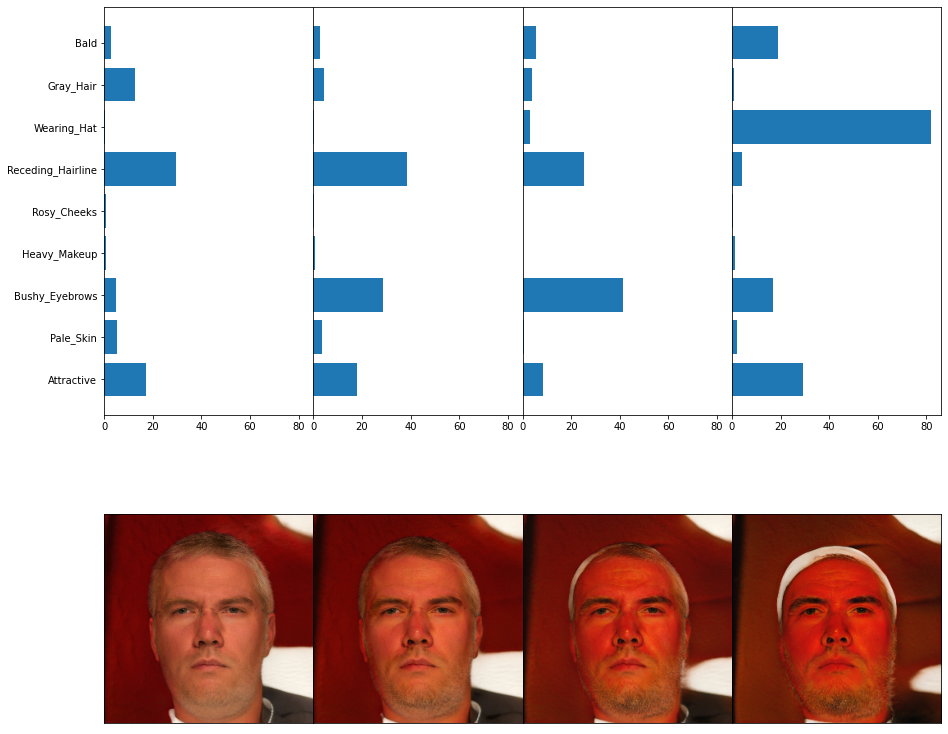

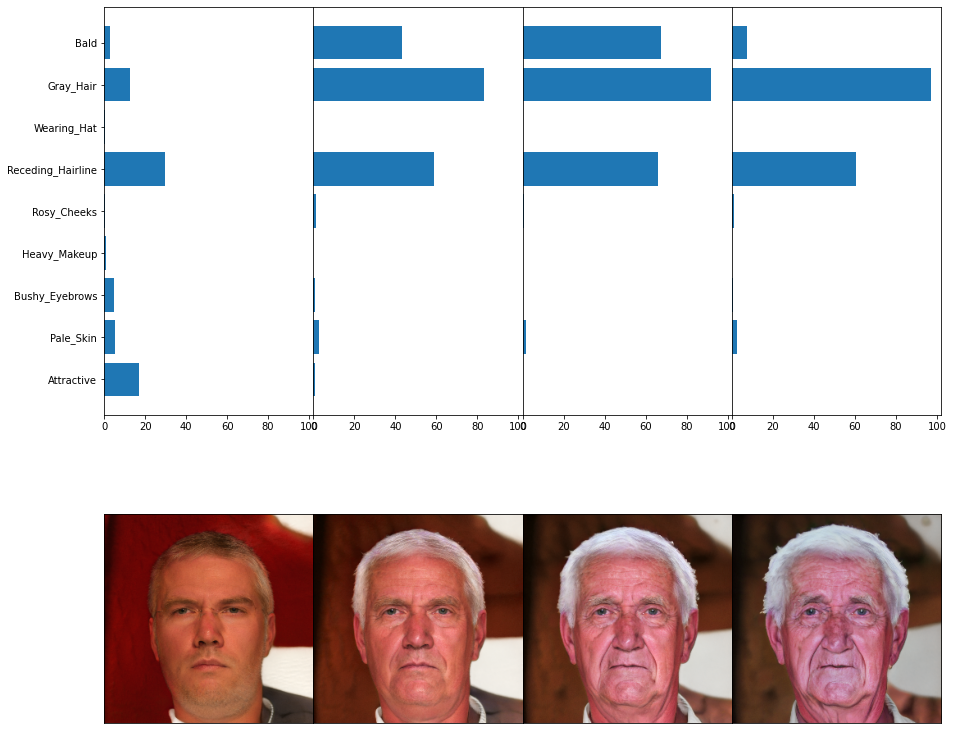

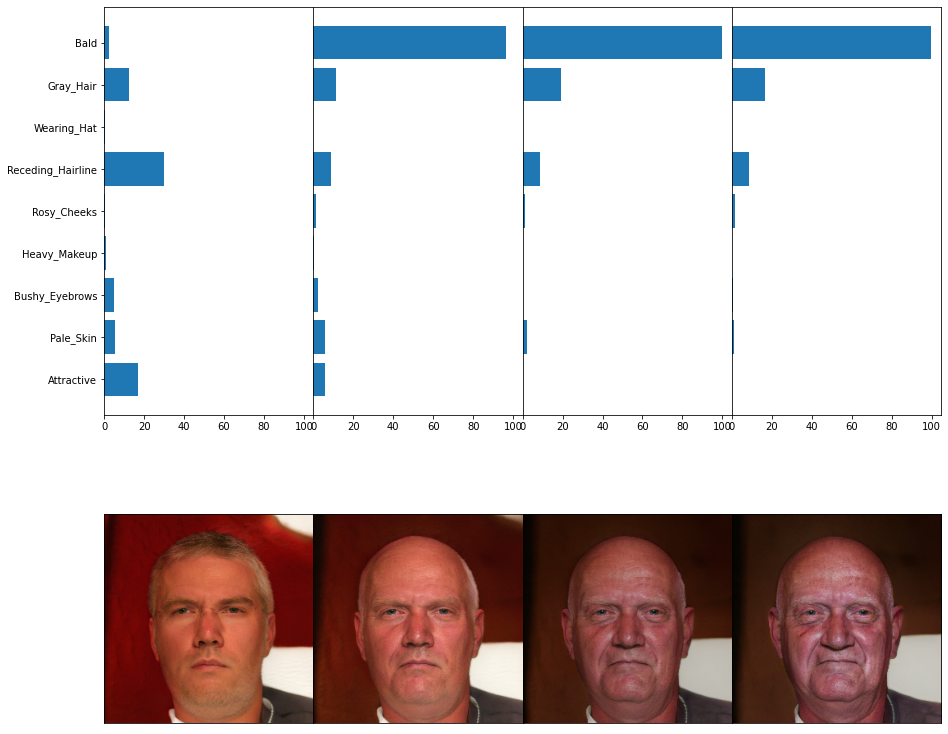

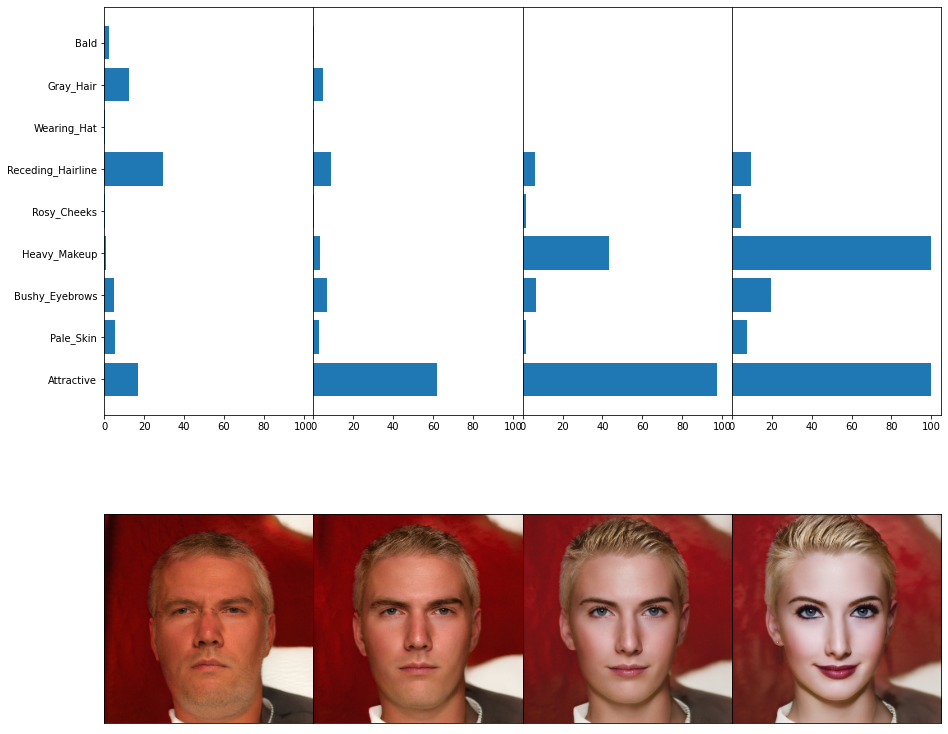

In [92]:
for d in dir_pred:
    inter_points = linspace(w ,w + d,path_steps)
    fig, axs = plt.subplots(2,len(inter_points),figsize=(15,15))
    
    
    y_max = 0
    for step,w_i in enumerate(inter_points):
        img = G.style_gan2([w_i], input_is_latent=True)[0]
        img = resize_transform(img)
        y = classifier(img)[0][:,args.subset_labels+args.target_label]
        y = torch.sigmoid(y)[0]
        y = y.cpu().detach().numpy() * 100
        y_max = max(y_max,y.max().item())
    
    for step,w_i in enumerate(inter_points):
        img = G.style_gan2([w_i], input_is_latent=True)[0]
        img = resize_transform(img)
        y = classifier(img)[0][:,args.subset_labels+args.target_label]
        y = torch.sigmoid(y)[0]
        y = y.cpu().detach().numpy() * 100

        img_np = img[0].permute(1,2,0).cpu().detach().numpy()
        img_norm = (img_np - img_np.min())/(img_np.max() - img_np.min())
        axs[1][step].imshow((img_norm * 255).astype(np.uint8))
        axs[1][step].set_xticks([])
        axs[1][step].set_yticks([])
        #axs[1][step].set_title("\n".join(["{} %{:1.0f}".format(lbl,yi) for lbl,yi in zip(labels,y)]))
        axs[0][step].barh(labels, y, align='center')
        axs[0][step].set_xlim([0, 1.05 * y_max])
        if step > 0:
            axs[0][step].set_yticks([])
        
        
    plt.subplots_adjust(wspace=0, hspace=0)

In [19]:
#generate tabular data of feature attributes value adn attractive value obtained from clf after moving in 
#arbitrarty directions optimizing arbitrary things at once. you eseentially have a dataset where you know value based
# off each sub attirbute and corresponding target label value from bbox clf. now you can explain target using
#these attributes' importance, but we also need some supporting images to justify this

In [ ]:
#v(Sui)-V(S)

In [20]:
#code original shapley by getting v(S) on the fly
#can give avg image of with S set and Sui set as image explanations to accompany raw values

In [21]:
from itertools import compress, product

def combinations(items):
    return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

In [22]:
grand_coalition=[1,25,11,17,28,27,34,16,3]#remove attractive 1
grand_coalition=set([25,11,17,28,27,34,16,3])#remove attractive 1

In [23]:
import math
def coalition_wt(N,S):
    num=math.factorial(S)*math.factorial(N-S-1)
    den=math.factorial(N)
    return num/den

In [62]:
def get_sample():#add functionality to plot this original sample
    z_perturb = torch.randn([1,latent_size]).repeat(batch_size,1).to(device)
    w = G.style_gan2.get_latent(z_perturb)
    img_orig = G.style_gan2([w], input_is_latent=True)[0]
    img_orig = resize_transform(img_orig)
    y_orig = classifier(img_orig)
    y_orig = torch.sigmoid(y_orig[0])
    print(y_orig[0][1])
    plt.imshow(img_orig[0].permute(1,2,0).detach().cpu().numpy())
    return w
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0923, device='cuda:0', grad_fn=<SelectBackward>)


tensor([[-1.6238e-01, -1.1778e-01, -4.6292e-01, -1.6533e-01, -1.2888e-01,
         -2.7770e-01, -2.1282e-01, -3.0361e-01,  3.8413e-01,  7.7972e-01,
          3.4981e-01, -1.8938e-01, -1.2079e-01, -3.8380e-03, -1.9677e-01,
         -3.7479e-01, -8.9016e-02, -2.8118e-01,  3.9971e-02, -2.8477e-01,
         -2.2816e-02, -2.1651e-01, -4.5379e-02, -1.2615e-01,  1.0443e+00,
         -2.1468e-01, -1.9323e-01,  9.2638e-01,  2.6805e-01, -3.4769e-02,
         -2.8212e-01,  1.2220e-02,  6.6616e-01,  2.1195e-01,  1.6323e-01,
         -1.4997e-01, -1.0071e-01, -1.8329e-01, -1.0942e-02, -1.8157e-01,
         -1.8107e-01, -1.7025e-01,  3.9107e-01,  7.8600e-01, -2.3882e-01,
         -3.7239e-02,  3.1552e-01, -1.2434e-01,  1.0417e+00, -2.7858e-01,
          2.2250e-01,  7.7997e-01,  3.1116e-02, -3.7092e-01, -1.4442e-01,
          1.0071e+00,  6.4445e-01, -2.0527e-01, -4.7250e-01, -1.0204e-01,
         -9.7760e-02, -2.6441e-01, -5.8589e-02, -5.3799e-02,  3.7180e-01,
          1.0282e+00, -2.0109e-01, -4.

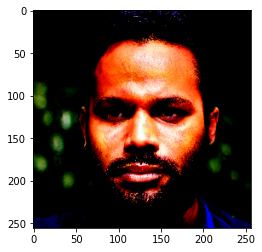

In [63]:
get_sample()

In [127]:
def val(S,gc,attribute_count,w):
    
    
    #w_rep = w.repeat(attribute_count,1)--no need to repeat
    y_target = torch.zeros(attribute_count).to(device)#--y_target will be generated based on S
    for each_ft in S:
        y_target[gc.index(each_ft)]=1
    y_target=y_target.reshape(1,-1)
    #print(y_target.shape)
    #print(w.shape)
    dir_pred = shift_model(w,y_target)
   
    #now create new latent space by going in dir,then new image, and pass thru clf and get output
    w_i = w+dir_pred/5#10 worked with example below, changing it now
    img = G.style_gan2([w_i], input_is_latent=True)[0]
    img = resize_transform(img)
    y = classifier(img)[0][:,args.subset_labels+args.target_label]#ASK-how to get attractive from this?
    y = torch.sigmoid(y)[0]
    if len(set(S))==len(gc) or len(set(S))==0:#plot the gc and empty
        plt.imshow(img[0].permute(1,2,0).detach().cpu().numpy());
        plt.show();
        print(y[0])
    y = y.cpu().detach().numpy()
    return y[0]#attractiveness?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7903, device='cuda:0', grad_fn=<SelectBackward>)


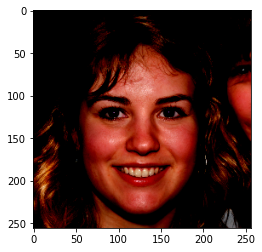

In [67]:
w=get_sample()

In [91]:
ft_map={1:"Attractive",
       25:"Pale_Skin",
       11:"Bushy_Eyebrows",
       17:"Heavy_Makeup",
       28:"Rosy_Cheeks",
       27:"Receding_hairline",
       34:"Wearing_Hat",
       16:"Gray_Hair",
       3:"Bald"}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


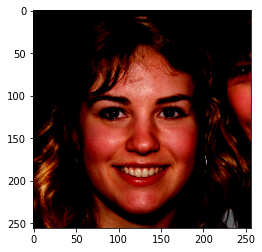

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


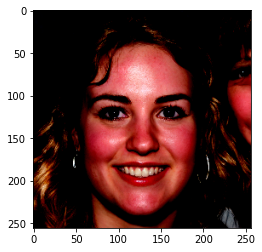

tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


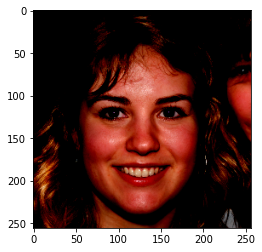

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


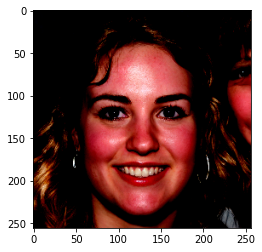

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
11


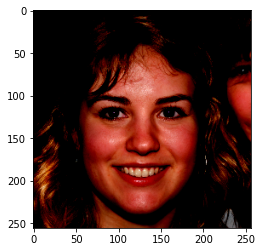

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


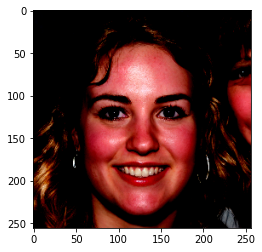

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
16


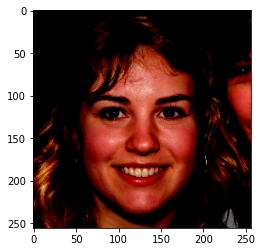

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


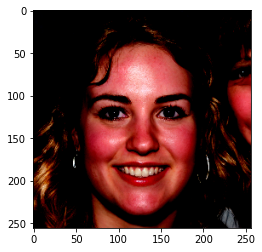

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
17


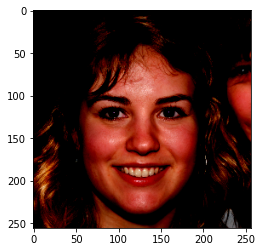

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


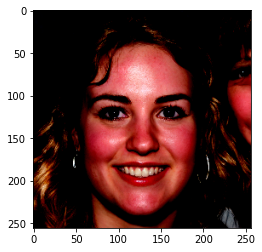

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
25


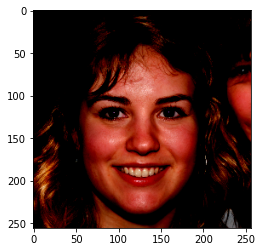

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


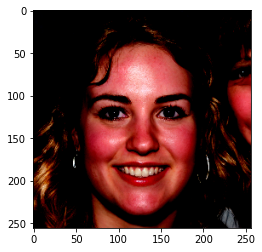

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
27


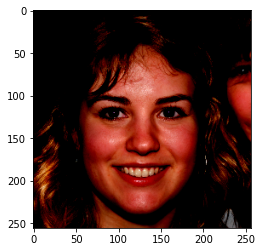

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


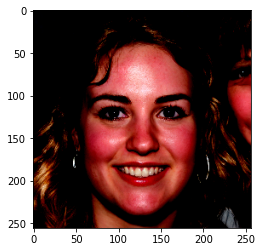

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)
28


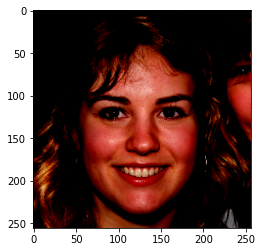

tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


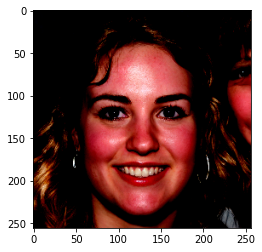

tensor(0.9072, device='cuda:0', grad_fn=<SelectBackward>)


In [92]:
#importance of first feature

ft_imp={}
for first_ft in list(grand_coalition):
    print(first_ft)
    phi_i=0
    s_wo_i=set(grand_coalition).difference(set([first_ft]))

    #find all possible subsets of s_wo_i
    all_subsets=list(combinations(s_wo_i))
    #iterate over multiple samples
    
    #go over all subsets, and do val(Sui)-val(S)

    for each_subset in all_subsets:
        v_s=val(each_subset,list(grand_coalition),attribute_count,w)
        v_si=val(set(each_subset).union(set([first_ft])),list(grand_coalition),attribute_count,w)
        wt=coalition_wt(len(grand_coalition),len(each_subset))
        phi_i+=wt*(v_si-v_s)
    ft_imp[ft_map[first_ft]]=phi_i
    

# not much useful as it is comparing original image to this image which is trying to be maximized in all directions simultaneously

## Maybe i can change what shapley gc is. instead of all set to 1, i choose which are set to 1.

In [93]:
dict(sorted(ft_imp.items(), key=lambda item: item[1]))

{'Receding_hairline': -0.10026034418316114,
 'Rosy_Cheeks': -0.0731284423243432,
 'Wearing_Hat': -0.028445231063025347,
 'Heavy_Makeup': -0.019177915971903572,
 'Pale_Skin': 0.024040656891607125,
 'Bald': 0.0727112095980417,
 'Gray_Hair': 0.0832394116336391,
 'Bushy_Eyebrows': 0.158890964197261}

In [95]:
#bushy eyebrows inc attractiveness

In [94]:
s=0
for k,v in ft_imp.items():
    s+=v
print(s)

0.11787030877811569


In [ ]:
s=0
for k,v in ft_imp.items():
    s+=v
print(s)#also need val of empty coalition--avg baseline value

In [173]:
#[1,25,11,17,28,27,34,16,3] #add attracitve# Pale_Skin, Bushy_Eyebrows, Heavy_Makeup, Rosy_Cheeks, Receding_hairline, Wearing_Hat, Gray_Hair, Bald

## Questions
1. this is a regressor?--looks like clf just prob*100
2. what is max and min value of attractiveness
3. need more senstiive features
4. how do i interpret shapley vlaues here?-marginal change in atttractiveness when we mvoe in dir of ft_t in all possible coalitions as compared to moving in opposite direction of not setting?
5. when all are set to 1, eveyr image essentially arives at a similar looking image-is this concerning--they are not attractive too?--not come at same , reduce dir by dir/10,,now diff image,more rrelevant/
6. empty coalition is moving in direction when all attributes 0. why is this not same as orig image--it is. but then why is attractiveness diff?--shapley imp correct now was selecting wrong from y
7. can we constraint to produce more attractive images only when setting dires-yes--can this be used through shapley to explain how much setting each helped inc attractiveness? or generalise this, to make either more or less atrractive depending on orginal image was attractive or not-flip label--we can create a flipped label person in gc and explain that wrt original image which was empty coalition


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1246, device='cuda:0', grad_fn=<SelectBackward>)


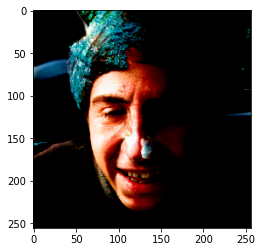

In [106]:
w=get_sample()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


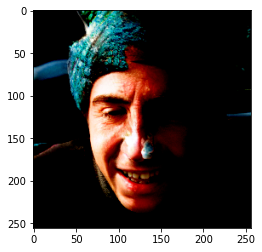

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


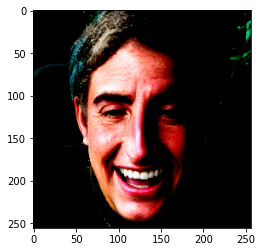

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
3


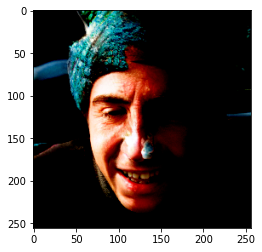

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


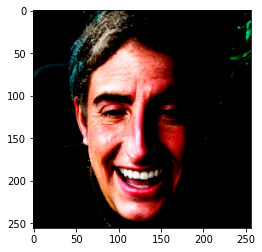

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
11


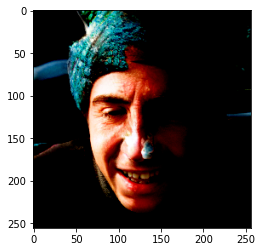

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


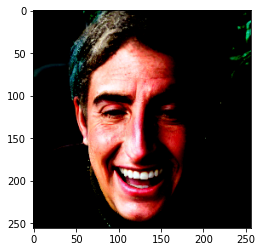

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
16


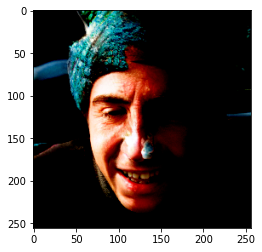

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


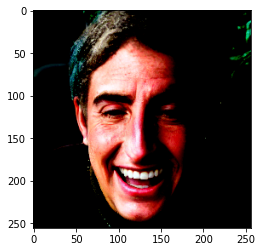

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
17


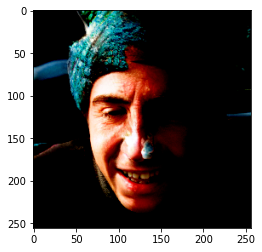

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


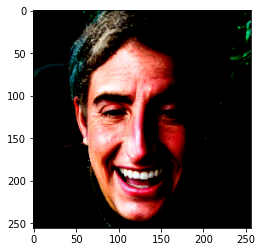

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
25


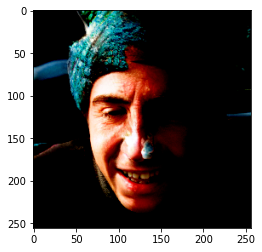

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


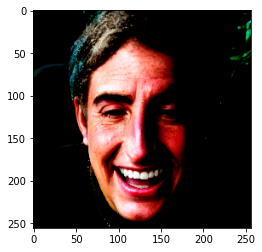

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
27


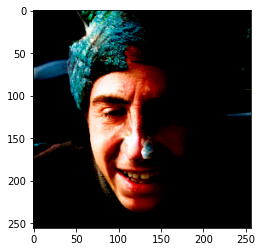

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


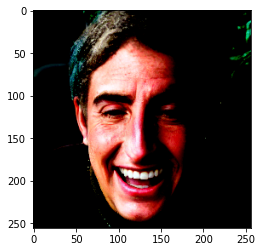

tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)
28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


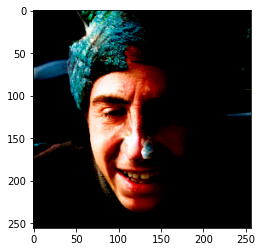

tensor(0.1440, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


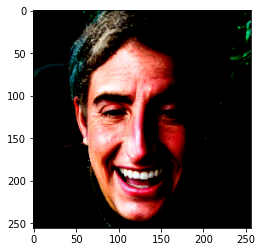

tensor(0.3006, device='cuda:0', grad_fn=<SelectBackward>)


In [107]:
#importance of first feature

ft_imp={}
for first_ft in list(grand_coalition):
    print(first_ft)
    phi_i=0
    s_wo_i=set(grand_coalition).difference(set([first_ft]))

    #find all possible subsets of s_wo_i
    all_subsets=list(combinations(s_wo_i))
    #iterate over multiple samples
    
    #go over all subsets, and do val(Sui)-val(S)

    for each_subset in all_subsets:
        v_s=val(each_subset,list(grand_coalition),attribute_count,w)
        v_si=val(set(each_subset).union(set([first_ft])),list(grand_coalition),attribute_count,w)
        wt=coalition_wt(len(grand_coalition),len(each_subset))
        phi_i+=wt*(v_si-v_s)
    ft_imp[ft_map[first_ft]]=phi_i
    

In [108]:
dict(sorted(ft_imp.items(), key=lambda item: item[1]))

{'Rosy_Cheeks': -0.07912366060717471,
 'Receding_hairline': -0.056567014775992845,
 'Heavy_Makeup': -0.025093609671152775,
 'Pale_Skin': 0.030590602159056623,
 'Gray_Hair': 0.04449095222655505,
 'Wearing_Hat': 0.04671903640430953,
 'Bald': 0.07322872564240937,
 'Bushy_Eyebrows': 0.1223799097883914}

In [109]:
## Why only bushy eyebrows

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6150, device='cuda:0', grad_fn=<SelectBackward>)


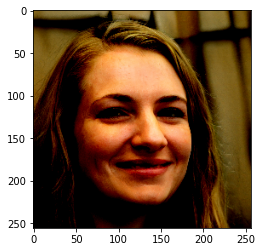

In [152]:
w=get_sample()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


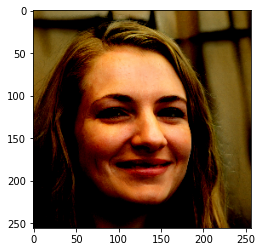

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


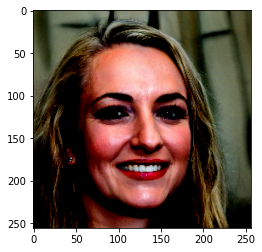

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
3


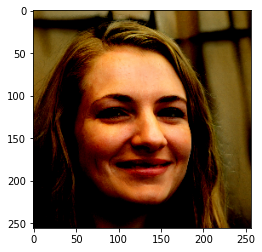

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


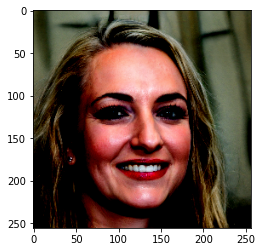

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
11


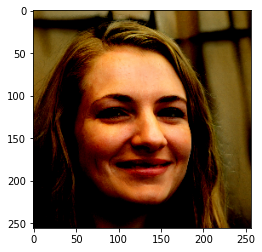

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


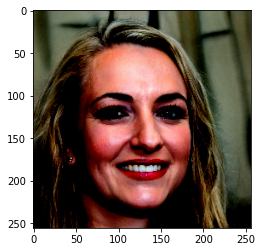

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
16


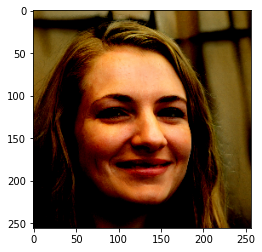

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


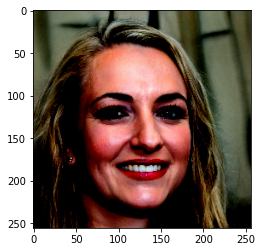

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
17


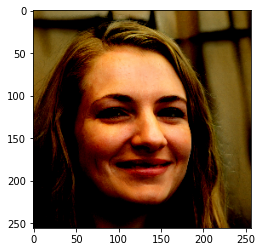

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


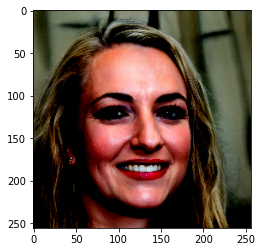

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
25


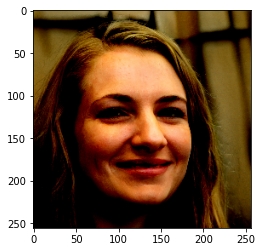

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


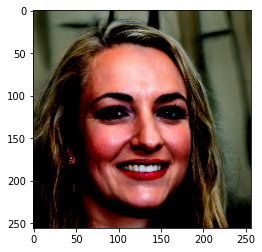

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
27


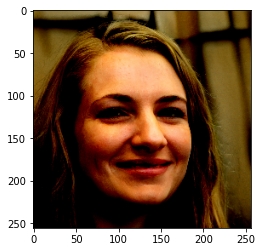

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


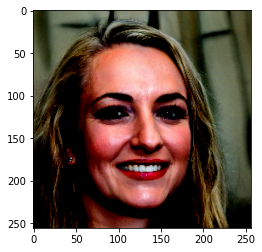

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)
28


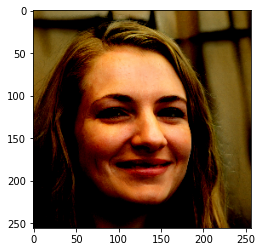

tensor(0.6232, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


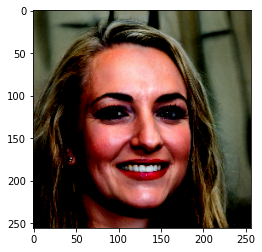

tensor(0.8123, device='cuda:0', grad_fn=<SelectBackward>)


In [153]:
#importance of first feature

ft_imp={}
for first_ft in list(grand_coalition):
    print(first_ft)
    phi_i=0
    s_wo_i=set(grand_coalition).difference(set([first_ft]))

    #find all possible subsets of s_wo_i
    all_subsets=list(combinations(s_wo_i))
    #iterate over multiple samples
    
    #go over all subsets, and do val(Sui)-val(S)

    for each_subset in all_subsets:
        v_s=val(each_subset,list(grand_coalition),attribute_count,w)
        v_si=val(set(each_subset).union(set([first_ft])),list(grand_coalition),attribute_count,w)
        wt=coalition_wt(len(grand_coalition),len(each_subset))
        phi_i+=wt*(v_si-v_s)
    ft_imp[ft_map[first_ft]]=phi_i
    

In [154]:
dict(sorted(ft_imp.items(), key=lambda item: item[1]))

{'Rosy_Cheeks': -0.1602222546048107,
 'Receding_hairline': -0.1060315171788846,
 'Heavy_Makeup': -0.08207041772880722,
 'Wearing_Hat': 0.05028751943083034,
 'Pale_Skin': 0.06211805431438344,
 'Gray_Hair': 0.07486328785085963,
 'Bald': 0.1216319553021873,
 'Bushy_Eyebrows': 0.22849521168640677}

In [156]:
## not too informative. every time bushy eyebrows -.-. we need more informative attributes like fairness, skin color
## attractiveness is too subjective! MNIST or bird animal something?
##bushy eyebrow and make up are correlated?